In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load Dataset

In [6]:
df = pd.read_excel("Online Retail.xlsx")  # or read_csv()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Clean the Data

In [7]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

Set Reference Date

In [8]:
import datetime as dt
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

Create RFM Table

In [9]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


 Assign RFM Scores (1 to 4 or 1 to 5)

In [10]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,114
1,12347.0,2,7,4310.00,4,4,4,444
2,12348.0,75,4,1797.24,2,3,4,234
3,12349.0,19,1,1757.55,3,1,4,314
4,12350.0,310,1,334.40,1,1,2,112


Create Customer Segments

In [11]:
def segment_customer(rfm):
    if rfm['RFM_Score'] == '444':
        return 'Best Customers'
    elif rfm['R_Score'] == '4':
        return 'Recent Customers'
    elif rfm['F_Score'] == '4':
        return 'Frequent Buyers'
    elif rfm['M_Score'] == '4':
        return 'Big Spenders'
    elif rfm['R_Score'] == '1':
        return 'Churned'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,4,114,Others
1,12347.0,2,7,4310.00,4,4,4,444,Best Customers
2,12348.0,75,4,1797.24,2,3,4,234,Others
3,12349.0,19,1,1757.55,3,1,4,314,Others
4,12350.0,310,1,334.40,1,1,2,112,Others


**Visualize the Segments**

Bar Plot

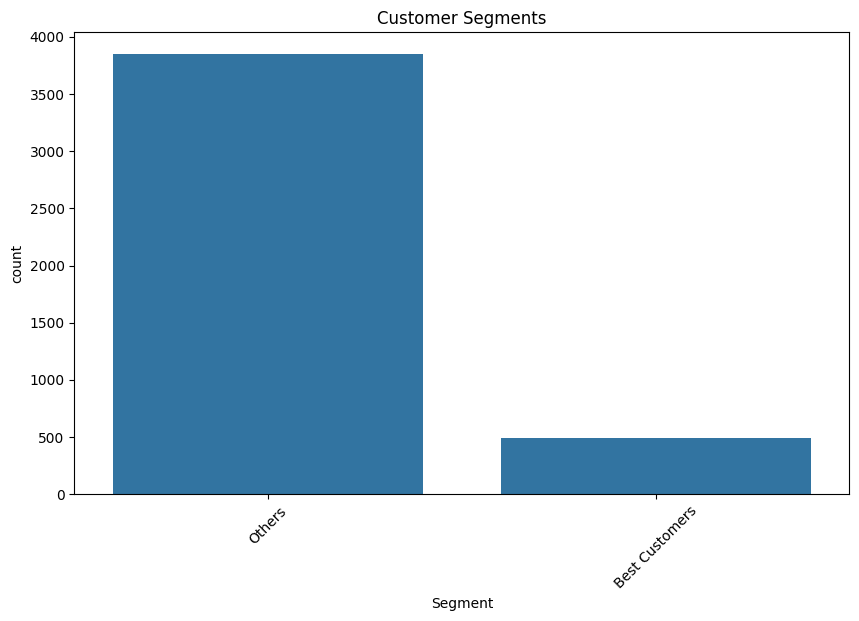

In [12]:
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments')
plt.xticks(rotation=45)
plt.show()

Heatmap of Average RFM

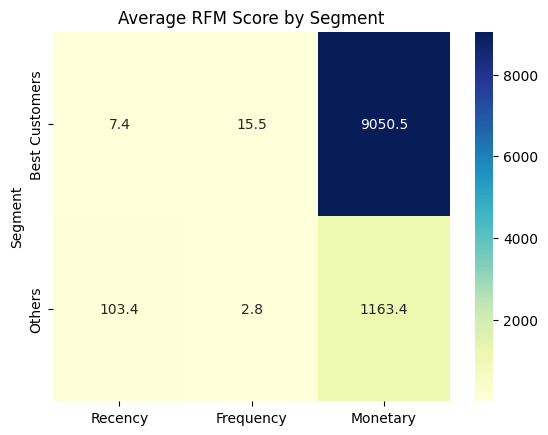

In [13]:
rfm_avg = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()
sns.heatmap(rfm_avg, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Average RFM Score by Segment')
plt.show()